In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


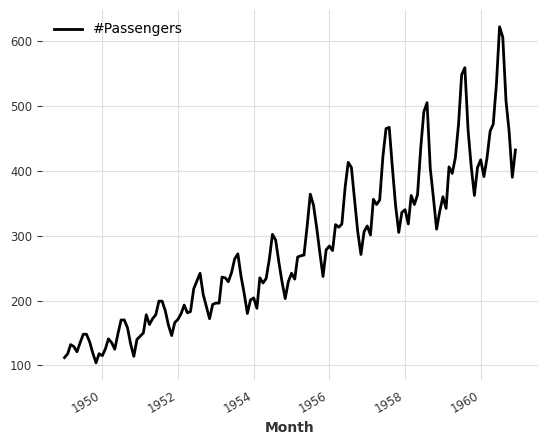

In [2]:
from darts import TimeSeries
from darts.datasets import AirPassengersDataset

series = AirPassengersDataset().load()
series.plot()


In [3]:
series.tail()

<TimeSeries (DataArray) (Month: 5, component: 1, sample: 1)>
array([[[606.]],

       [[508.]],

       [[461.]],

       [[390.]],

       [[432.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1960-08-01 1960-09-01 ... 1960-12-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

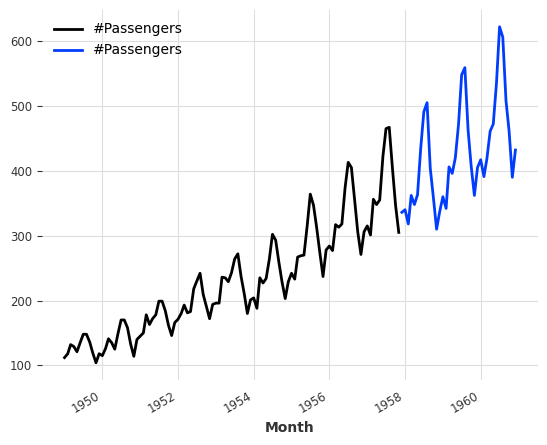

In [4]:
series1, series2 = series.split_before(0.75)
series1.plot()
series2.plot()

### noise in the series

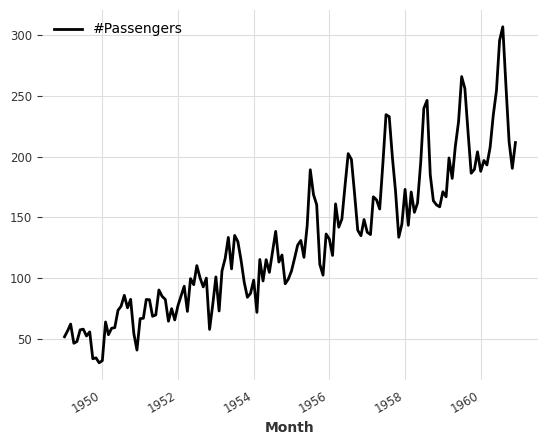

In [5]:
series_noise = TimeSeries.from_times_and_values(
    series.time_index, np.random.randn(len(series))
)
(series / 2 + 10 * series_noise - 10).plot()

### train and val and fitting

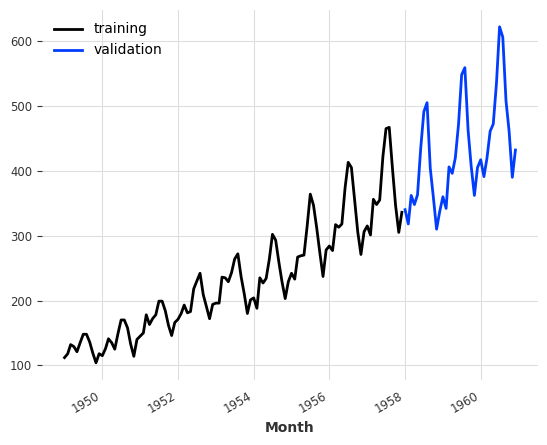

In [6]:
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

/home/mahdigilany/anaconda3/envs/borealis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


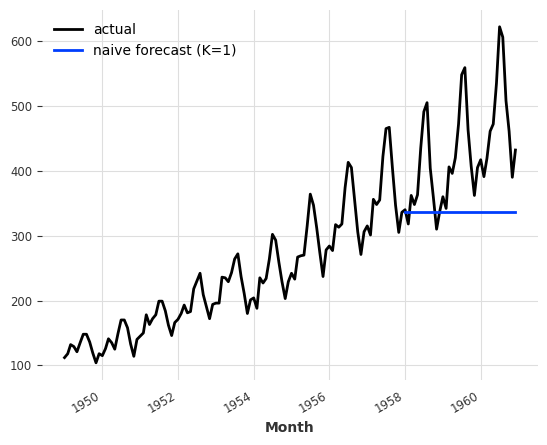

In [7]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

### combined method

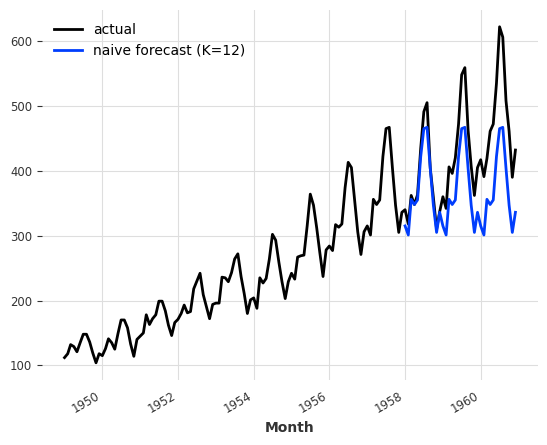

In [8]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

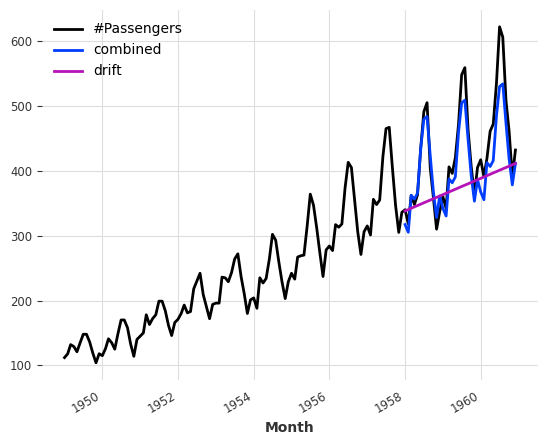

In [9]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [10]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


In [11]:
from omegaconf import OmegaConf
import hydra
